## Acceleration of a FIR filter
Reference: http://www.fpgadeveloper.com/2018/03/how-to-accelerate-a-python-function-with-pynq.html

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_signal(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.xlabel('Time (μs)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'r-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

### Generate the input signal
Generating a noisy signal and extracting the primary 200kHz signal.

Number of samples:  200000


<IPython.core.display.Javascript object>


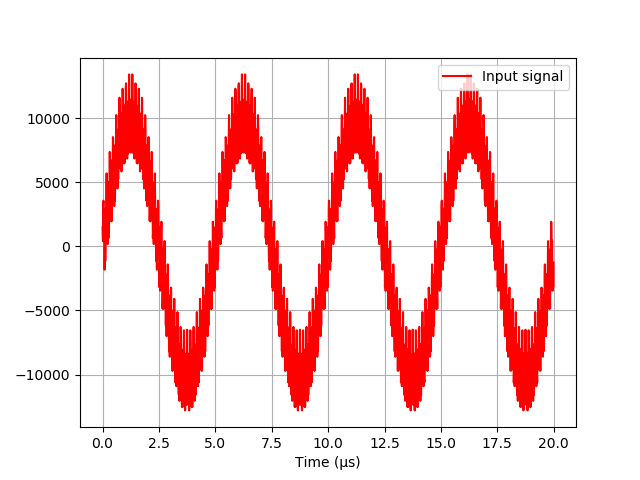

In [6]:
import numpy as np

T = 0.002       # Total time
fs = 100e6      # Sampling frequency
n = int(T * fs) # Number of samples
t = np.linspace(0, T, n, endpoint=False)   # Time vector in seconds

# Signals to be combined
s1 = 10000*np.sin(0.2e6*2*np.pi*t)
s2 = 1500*np.cos(28e6*2*np.pi*t)
s3 = 2000*np.sin(7e6*2*np.pi*t)
samples = s1 + s2 + s3
samples = samples.astype(np.int32) # Convert samples to 32-bit integers
                  
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_signal(t,samples,2000)

### Software FIR filter using SciPy
Low pass filter with passband 0-5MHz. Generated using: http://t-filter.engineerjs.com/

Software FIR execution time:  0.0856924057006836


<IPython.core.display.Javascript object>


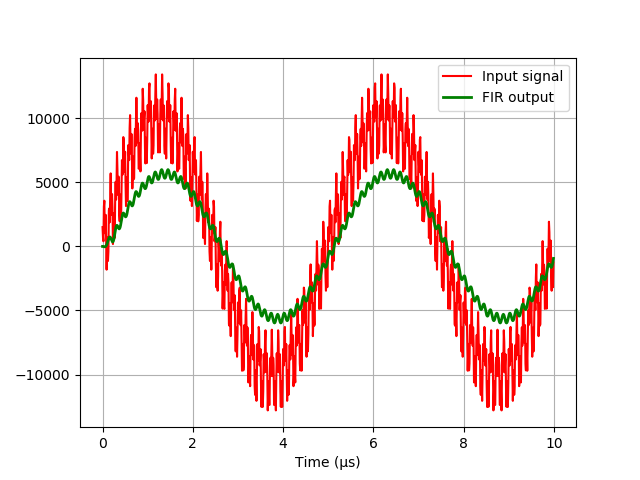

In [7]:
from scipy.signal import lfilter

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

import time
start_time = time.time()
sw_fir_output = lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ',sw_exec_time)

# Plot the result to notebook
plot_signal(t,samples,1000,out_signal=sw_fir_output)

### Hardware FIR Filter

In [8]:
from pynq import Overlay
import pynq.lib.dma
overlay = Overlay('fir_accel.bit')
dma = overlay.filter.fir_dma

Hardware FIR execution time:  0.004364967346191406
Hardware acceleration factor:  19.631854926807954


<IPython.core.display.Javascript object>


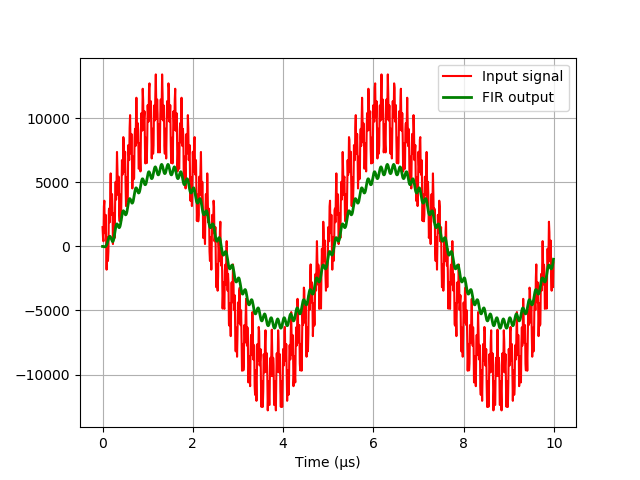

In [9]:
from pynq import Xlnk
import numpy as np

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)

# Plot to the notebook
plot_signal(t,samples,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()